# Homework 6 (more of a tutorial, really)

As I was browsing through Kaggle the other day, I came upon a brand new dataset from the University of Puerto Rico, which contains images of bees entering their hive.  The task is to determine automatically which bees are carrying pollen.  Your job will be to develop a convolutional neural network that performs this task.  

## 1. Load Data (0 pts)

First, we need to load the bee data, which is included along with this homework.  Fortunately, the authors of the Kaggle dataset provided a nice set of files which will do this for us, which I have reproduced below

In [1]:
# Source: https://stackoverflow.com/questions/47286441/only-import-keras-takes-10gb-in-gpu
# This added cell fixes an issue with keras loading onto the gpu's RAM preventing larger batch sizes
# and more complicated models.

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
from keras import backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
session = tf.Session(config=config)
K.set_session(session)

Using TensorFlow backend.


In [2]:
import glob, os 
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
path="images/"
imlist= glob.glob(os.path.join(path, '*.jpg'))

In [4]:
def dataset(file_list,size=(300,180),flattened=False):
    data = []
    for i, file in enumerate(file_list):
        image = io.imread(file)
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()

        data.append(image)
    

    #labels = [1 if f.split("/")[-1][0] == 'P' else 0 for f in file_list]
    # Need to specify the split on the directory separator like this for windows
    labels = [1 if f.split("\\")[-1][0] == 'P' else 0 for f in file_list]

    return np.array(data), np.array(labels)

In [5]:
# Load the dataset (may take a few seconds)
X,y=dataset(imlist)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1)

num_classes = 2

import keras

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

C:\Users\nohbo\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
# X has the following structure: X[imageid, y,x,channel]
print('X: ',X.shape)  # data
print('y: ',y.shape)  # target

print('Class 0: ',sum(y==0))
print('Class 1: ',sum(y==1))
print('Total  : ',len(y))


X:  (714, 300, 180, 3)
y:  (714,)
Class 0:  345
Class 1:  369
Total  :  714


We can plot a couple of the images below.  If you check out a couple of these, you will see that the visible difference when bees carry pollen is the presence of large fluffy balls of pollen on their back legs.

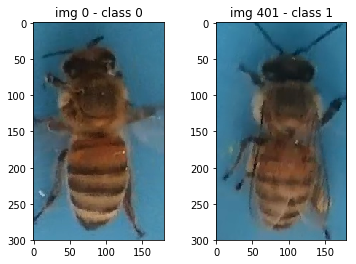

In [7]:
fig, axes = plt.subplots(1,2)
k=0
plt.sca(axes[0])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]))

k=401
plt.sca(axes[1])
plt.imshow(X[k])
plt.title('img {} - class {}'.format(k, y[k]));

## 2. A convolutional network architecture for bee classification (40 pts)

**Implement a 2D convolutional neural network using Keras.  You are free to choose whatever network architecture you like.**

You can find all the relevant syntax for implementing such a network [here](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py), the Keras convnet example for MNIST.

*(For the sake of comparison, I will share the one that I used:*

Layer 1: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 2: 4x4 Max-pooling layer

Layer 3: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 4: 4x4 Max-pooling layer

Layer 5: 5x5 convolution layer with 24 kernels and a relu activation function

Layer 6: 4x4 Max-pooling layer

Layer 7: Flattening layer

Layer 8: Dropout layer with 0.2 dropout probability

Layer 9: 1 node sigmoid layer


In [8]:
from __future__ import print_function
import keras
import keras.models as km
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers

import numpy as np
import tensorflow as tf

input_shape = ((300,180,3))

model = km.Sequential()

#! Add layers to your convolutional neural network 
model.add(Conv2D(24, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(24, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(24, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(2, activation = 'sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 296, 176, 24)      1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 44, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 40, 24)        14424     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 10, 24)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 6, 24)         14424     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 1, 24)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
__________

## 3. Fitting the CNN to data (20 pts)

Compile your model, using a binary crossentropy loss function and an optimizer of your choosing (RMSprop worked well for me).  Select a batch size and number of epochs, and fit your model to the training data, while also keeping track of the test set accuracy.

**Plot the training and test accuracy of your model at each epoch.  Comment on whether you think the model is being overfit.**

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy,   #! Specify a loss function
              optimizer=keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),        #! Specify an optimizer
              metrics=['accuracy'])

batch_size = 16                       #! Specify a batch size
epochs= 20                            #! Specify an epoch  
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test,y_test))

Train on 571 samples, validate on 143 samples
Epoch 1/20
571/571 [==============================] - 12s 21ms/step - loss: 0.6926 - acc: 0.5552 - val_loss: 0.6916 - val_acc: 0.4825
Epoch 2/20
571/571 [==============================] - 3s 4ms/step - loss: 0.6409 - acc: 0.6375 - val_loss: 0.6141 - val_acc: 0.6993
Epoch 3/20
571/571 [==============================] - 1s 3ms/step - loss: 0.5558 - acc: 0.7513 - val_loss: 0.4805 - val_acc: 0.8042
Epoch 4/20
571/571 [==============================] - 1s 2ms/step - loss: 0.5143 - acc: 0.7320 - val_loss: 0.4132 - val_acc: 0.8252
Epoch 5/20
571/571 [==============================] - 1s 2ms/step - loss: 0.4827 - acc: 0.7688 - val_loss: 0.3804 - val_acc: 0.8601
Epoch 6/20
571/571 [==============================] - 1s 2ms/step - loss: 0.4349 - acc: 0.7916 - val_loss: 0.3752 - val_acc: 0.8392
Epoch 7/20
571/571 [==============================] - 1s 2ms/step - loss: 0.3869 - acc: 0.8196 - val_loss: 0.4403 - val_acc: 0.8042
Epoch 8/20
571/571 [========

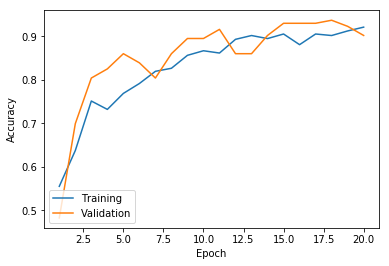

In [10]:
#! Plot test and training accuracy (note that the history.history object is a dictionary containing relevant info)
train_acc = history.history['acc']
val_acc = history.history['val_acc']

xs = [i+1 for i in range(epochs)]

plt.plot(xs,train_acc)
plt.plot(xs,val_acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'], loc='lower left')
plt.show()


# The training and validation accuracies seem to plateau at the same rate. To me, this plot suggests that
# overfitting has not yet occurred since the validation accuracy didn't peak early in the epochs. If overfitting had
# occurred then we would expect to lose validation accuracy as we continue since the variance would be too entangled
# in the model's calculated parameters leading to bad predictions from loss of true underlying relationship.

## 4. Model evaluation (20 pts)

Now that you have a trained model, make a prediction for the test set (model.predict is a useful function for this).  **Compute and display a confusion matrix.  Select and display an example from the test set of a true positive, a true negative, a false positive, and a false negative.  Speculate on the reasons behind misclassification for images that your model predicted incorrectly**.

In [24]:
#! See above
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test, batch_size=batch_size)
# argmax determines which class had the most weight (e.g. predicted)
c = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
accuracy = np.diagonal(c).sum()/c.sum()

print("Confusion matrix: \n", c)
print("Classification accuracy: ", accuracy)

Confusion matrix: 
 [[65  3]
 [ 4 71]]
Classification accuracy:  0.951048951048951


Incorrects: [89, 93, 95, 113, 123, 124, 136]


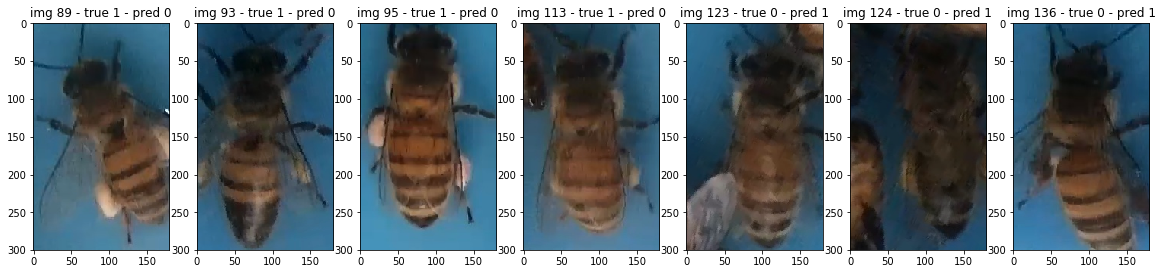

In [25]:
# Find the ids of the misclassified
incorrects = [i for i in range(len(y_test.argmax(axis=1))) if y_test.argmax(axis=1)[i] != y_pred.argmax(axis=1)[i]]
print('Incorrects:',incorrects)

fig, axes = plt.subplots(1,len(incorrects))
fig.set_size_inches(20, 20)

# Show the wrong misclassified
for i,k in enumerate(incorrects):
    plt.sca(axes[i])
    plt.imshow(X_test[k])
    plt.title('img {} - true {} - pred {}'.format(k, y_test[k].argmax(), y_pred[k].argmax()));

The problems in these images could be due to the orientation and position of the bees. 1 and 7 the bodies are tilted. 5 and 6 are off center. The resolution in 6 or the object in the lower left of 5 might be why they both registered as false positives. The relatively hidden pollen in 2 and 4 (in the shadows of the body) might have caused the false negatives. It is a bit unfortunate that the first four which are false negatives are more clearly discernible to the human eye than the model provided.

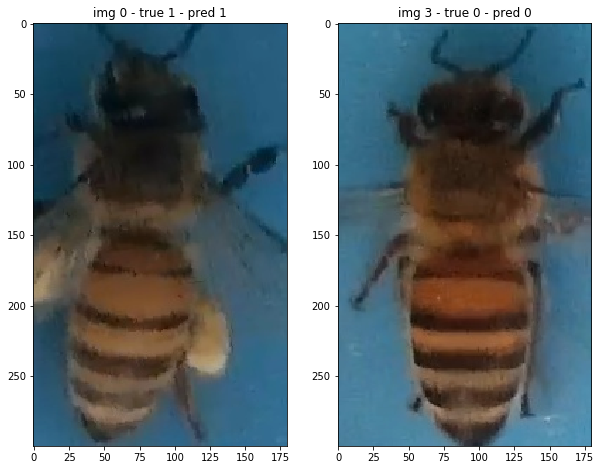

In [29]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(10, 10)

# True positive
k=0
plt.sca(axes[0])
plt.imshow(X_test[k])
plt.title('img {} - true {} - pred {}'.format(k, y_test[k].argmax(), y_pred[k].argmax()));

# True negative
k=3
plt.sca(axes[1])
plt.imshow(X_test[k])
plt.title('img {} - true {} - pred {}'.format(k, y_test[k].argmax(), y_pred[k].argmax()));

These examples of a true positive and a true negative clearly show the bees well oriented and positioned to see the hind legs well enough to discern whether there are clumps of pollen around them.